## DDPG

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework import ops

tf.disable_v2_behavior()

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

ops.reset_default_graph()

#### environment

In [2]:
ENV_NAME = 'Pendulum-v1'
env = gym.make(ENV_NAME)

np.random.seed(123)
env.seed(123)

assert len(env.action_space.shape) == 1

nb_actions = env.action_space.shape[0]

#### Actor build

In [3]:
actor = tf.keras.Sequential()

actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))

print(actor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0

#### Critic build

In [4]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)

x = Concatenate()([action_input, flattened_observation])

x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)

critic = Model(inputs=[action_input, observation_input], outputs=x)

print(critic.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 3)]       0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3)            0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4)            0           action_input[0][0]               
                                                                 flatten_1[0][0]              

#### Agent compile

In [5]:
memory = SequentialMemory(limit=100000, window_length=1)

random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.15, mu=0.0, sigma=0.3)

agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    memory=memory,
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,
    random_process=random_process,
    gamma=0.99,
    target_model_update=1e-3,
)

In [6]:
agent.compile(Adam(lr=0.001, clipnorm=1.0), metrics=['mae'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-04-18 23:12:01.454457: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 23:12:01.468054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [7]:
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 17:12 - reward: -1.7128

/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 38s 4ms/step - reward: -6.4807
50 episodes - episode_reward: -1296.148 [-1686.273, -791.872] - loss: 2.581 - mean_absolute_error: 0.506 - mean_q: -30.434

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: -2.5237
50 episodes - episode_reward: -504.732 [-1492.420, -1.010] - loss: 12.304 - mean_absolute_error: 1.132 - mean_q: -66.397

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 49s 5ms/step - reward: -1.4854
50 episodes - episode_reward: -297.078 [-904.815, -5.714] - loss: 14.583 - mean_absolute_error: 1.296 - mean_q: -62.014

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: -1.2242
50 episodes - episode_reward: -244.840 [-582.405, -5.947] - loss: 16.992 - mean_absolute_error: 1.550 - mean_q: -56.630

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 47s 5ms/step 

In [8]:
env.close()

In [9]:
agent.save_weights('ddpg_weights.h5f')

[WARNING] ddpg_weights_actor.h5f.index already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


[WARNING] ddpg_weights_critic.h5f.index already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


In [10]:
agent.load_weights('ddpg_weights.h5f')

In [11]:
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=300)
env.close()

Testing for 5 episodes ...
Episode 1: reward: -119.552, steps: 200
Episode 2: reward: -345.667, steps: 200
Episode 3: reward: -119.679, steps: 200
Episode 4: reward: -118.263, steps: 200
Episode 5: reward: -126.460, steps: 200


#### evaluate

In [12]:
scores = agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=300)
env.close()

Testing for 5 episodes ...
Episode 1: reward: -241.559, steps: 200
Episode 2: reward: -126.691, steps: 200
Episode 3: reward: -337.852, steps: 200
Episode 4: reward: -241.862, steps: 200
Episode 5: reward: -116.429, steps: 200


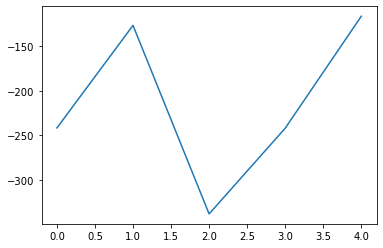

In [13]:
plt.plot(scores.history['episode_reward'])
plt.show()